参考：
- http://aidiary.hatenablog.com/entry/20180304/1520172429
- https://github.com/cross32768/VGAN/blob/master/VGAN.ipynb

In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from time import sleep
from tensorboardX import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(64, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Linear(1024, 128 * 8 * 8),
            nn.BatchNorm1d(128 * 8 * 8),
            nn.ReLU(),
        )
        
        # 128x8x8
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1), # -> 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # -> 64x32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1), # -> 3x64x64
            nn.BatchNorm2d(64),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 8, 8)
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 3x64x64
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # -> 64x32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> 128x16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1), # -> 128x8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        # -------------------------------- VDB
        self.conv_mean = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x8x8
        self.conv_logvar = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x8x8
        # --------------------------------
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        
        # -------------------------------- VDB
        mean = self.conv_mean(x).view(-1, 128 * 8 * 8)
        logvar = self.conv_logvar(x).view(-1, 128 * 8 * 8)
        noise = torch.randn(mean.size(), device=device)
        z = (0.5 * logvar).exp() * noise + mean
        # --------------------------------
        
        x = self.fc(z)
        return x, mean, logvar

In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [5]:
def train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta, writer, num_iter):

    y_real = torch.ones(batch_size, 1)
    y_fake = torch.zeros(batch_size, 1)
    
    y_real = y_real.to(device)
    y_fake = y_fake.to(device)

    D_running_loss = 0
    G_running_loss = 0
    
    for batch_idx, (real_images, _) in enumerate(tqdm(data_loader)):
        D.train()
        G.train()
        
        z = torch.rand((batch_size, z_dim))
        real_images, z = real_images.to(device), z.to(device)
        
        # ----------------------------------------------------------------
        # Discriminator update
        # ----------------------------------------------------------------
        D_optimizer.zero_grad()

        D_real, mean, logvar = D(real_images)
        D_real_loss, loss_kldiv_real = D_criterion(D_real, y_real, mean, logvar, beta)

        fake_images = G(z)
        
        D_fake, mean, logvar = D(fake_images.detach()) # ここはdetach?
        D_fake_loss, loss_kldiv_fake = D_criterion(D_fake, y_fake, mean, logvar, beta)

        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()

        # -------------------------------- VDB
        loss_kldiv = loss_kldiv_real.item() + loss_kldiv_fake.item()
        beta = max(0.0, beta + alpha * loss_kldiv)
        # -------------------------------- 
        
        # ----------------------------------------------------------------
        # Generator update
        # ----------------------------------------------------------------
        z = torch.rand((batch_size, z_dim))
        z = z.to(device)

        G_optimizer.zero_grad()

        fake_images = G(z)
        
        D_fake, mean, logvar = D(fake_images)
        G_loss = G_criterion(D_fake, y_real)
        
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
        
        # ----------------------------------------------------------------
        # TensorBoardX
        # ----------------------------------------------------------------
        writer.add_scalar('train_G_loss', G_loss.item(), num_iter)
        writer.add_scalar('train_D_loss', D_loss.item(), num_iter)
        writer.add_scalar('beta', beta, num_iter)
        if num_iter % 50 == 0:
            G.eval()
            sample_z = torch.rand((64, z_dim)).to(device)
            with torch.no_grad():
                sample = G(sample_z).to('cpu')
            writer.add_image('Image_from_latent', make_grid(sample, nrow=8, padding=1), num_iter)
        num_iter += 1
        
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss, num_iter, beta

In [6]:
def generate(epoch, G, log_dir='logs'):
    G.eval()
    
    os.makedirs(log_dir, exist_ok=True)

    sample_z = torch.rand((64, z_dim))
    sample_z = sample_z.to(device)
    
    with torch.no_grad():
        samples = G(sample_z).to('cpu')
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

In [7]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 64
num_epochs = 25
sample_num = 16
log_dir = './logs/vgan-celebA'

In [8]:
# load dataset
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder('data/celebA', transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)  

(-0.5, 325.5, 325.5, -0.5)

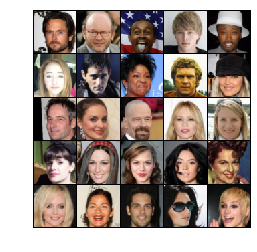

In [9]:
images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
plt.imshow(np.transpose(make_grid(images, nrow=5, padding=1).numpy(),(1, 2, 0)))
plt.axis('off')

In [10]:
G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# -------------------------------- VDB
I_c = 0.5
beta = 0 #1.0
alpha = 1e-5

def VDB_loss(out, label, mean, sigma, beta):
    normal_D_loss = torch.mean(F.binary_cross_entropy(out, label))
    
    kldiv_loss = - 0.5 * torch.mean(1 + sigma - mean.pow(2) - sigma.exp())
    kldiv_loss = kldiv_loss.mean() - I_c
    final_loss = normal_D_loss + beta * kldiv_loss
    
    return final_loss, kldiv_loss.detach()
# --------------------------------

G_criterion = nn.BCELoss()
D_criterion = VDB_loss

In [11]:
writer = SummaryWriter()

history = {}
history['D_loss'] = []
history['G_loss'] = []
num_iter = 0

for epoch in range(num_epochs):
    D_loss, G_loss, num_iter, beta = train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta, writer, num_iter)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # save
    generate(epoch + 1, G, log_dir)
    torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
    torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))
    sleep(0.5) # for tqdm(?)

100%|██████████| 1582/1582 [31:32<00:00,  1.20s/it]


epoch 1, D_loss: 1.3878 G_loss: 0.6935


100%|██████████| 1582/1582 [07:44<00:00,  3.40it/s]


epoch 2, D_loss: 1.3080 G_loss: 0.8260


100%|██████████| 1582/1582 [07:34<00:00,  3.48it/s]


epoch 3, D_loss: 1.3532 G_loss: 0.7384


100%|██████████| 1582/1582 [07:35<00:00,  3.48it/s]


epoch 4, D_loss: 1.2720 G_loss: 0.8383


100%|██████████| 1582/1582 [07:44<00:00,  3.40it/s]


epoch 5, D_loss: 1.1813 G_loss: 0.9550


100%|██████████| 1582/1582 [07:38<00:00,  3.45it/s]


epoch 6, D_loss: 1.1378 G_loss: 1.0213


100%|██████████| 1582/1582 [07:40<00:00,  3.44it/s]


epoch 7, D_loss: 1.1022 G_loss: 1.0782


100%|██████████| 1582/1582 [07:45<00:00,  3.40it/s]


epoch 8, D_loss: 1.0632 G_loss: 1.1330


100%|██████████| 1582/1582 [07:41<00:00,  3.43it/s]


epoch 9, D_loss: 1.0276 G_loss: 1.1971


100%|██████████| 1582/1582 [07:42<00:00,  3.42it/s]


epoch 10, D_loss: 0.9868 G_loss: 1.2659


100%|██████████| 1582/1582 [07:41<00:00,  3.43it/s]


epoch 11, D_loss: 0.9440 G_loss: 1.3470


100%|██████████| 1582/1582 [07:45<00:00,  3.40it/s]


epoch 12, D_loss: 0.9048 G_loss: 1.4256


100%|██████████| 1582/1582 [07:40<00:00,  3.43it/s]


epoch 13, D_loss: 0.8707 G_loss: 1.4992


100%|██████████| 1582/1582 [07:38<00:00,  3.45it/s]


epoch 14, D_loss: 0.8131 G_loss: 1.6079


100%|██████████| 1582/1582 [07:38<00:00,  3.45it/s]


epoch 15, D_loss: 0.7819 G_loss: 1.7064


100%|██████████| 1582/1582 [07:47<00:00,  3.39it/s]


epoch 16, D_loss: 0.7365 G_loss: 1.8094


100%|██████████| 1582/1582 [07:45<00:00,  3.40it/s]


epoch 17, D_loss: 0.7117 G_loss: 1.8773


100%|██████████| 1582/1582 [07:40<00:00,  3.43it/s]


epoch 18, D_loss: 0.6821 G_loss: 1.9726


100%|██████████| 1582/1582 [07:42<00:00,  3.42it/s]


epoch 19, D_loss: 0.6453 G_loss: 2.0718


100%|██████████| 1582/1582 [07:42<00:00,  3.42it/s]


epoch 20, D_loss: 0.6338 G_loss: 2.1340


100%|██████████| 1582/1582 [07:37<00:00,  3.46it/s]


epoch 21, D_loss: 0.6007 G_loss: 2.2225


100%|██████████| 1582/1582 [07:43<00:00,  3.42it/s]


epoch 22, D_loss: 0.5938 G_loss: 2.2816


100%|██████████| 1582/1582 [07:39<00:00,  3.44it/s]


epoch 23, D_loss: 0.5725 G_loss: 2.3497


100%|██████████| 1582/1582 [07:38<00:00,  3.45it/s]


epoch 24, D_loss: 0.5655 G_loss: 2.3837


100%|██████████| 1582/1582 [07:27<00:00,  3.54it/s]


epoch 25, D_loss: 0.5373 G_loss: 2.4756


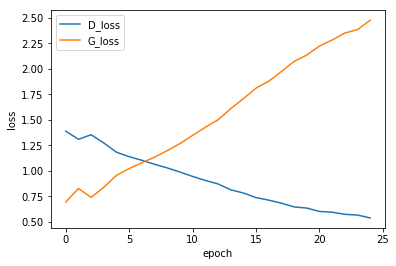

In [12]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

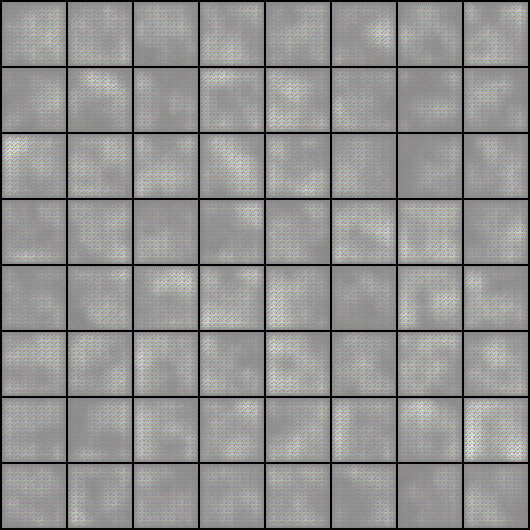

In [13]:
from IPython.display import Image
Image('logs/vgan-celebA/epoch_001.png')

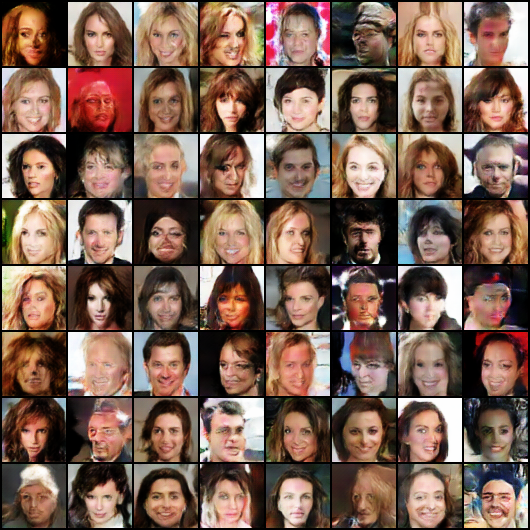

In [14]:
Image('logs/vgan-celebA/epoch_010.png')

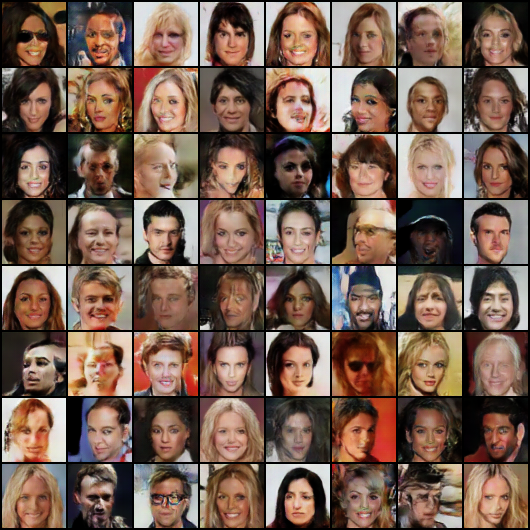

In [15]:
Image('logs/vgan-celebA/epoch_025.png')